# Análisis de Dispersión del Arancel: Carreras Largas vs. Cortas

Este análisis separa las carreras en dos grupos según su duración (hasta 8 semestres vs. más de 8 semestres) y compara la variabilidad de los aranceles usando el **Coeficiente de Variación (CV)**.

## Objetivo:
Determinar si los aranceles de las carreras más largas son más o menos variables que los de las carreras cortas mediante el análisis de dispersión.

In [ ]:
# Cargar datos e importar librerías necesarias
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Configuración para gráficos
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

print("Librerías importadas correctamente")

# Cargar datos
print("\nCargando datos...")
matriculas = pd.read_csv('../data/matriculas_ed_superior_nuble_2021.csv')
carreras = pd.read_csv('../data/carreras.csv')
instituciones = pd.read_csv('../data/instituciones.csv')

print(f"✅ Datos cargados:")
print(f"   - Matrículas: {len(matriculas):,} registros")
print(f"   - Carreras: {len(carreras):,} registros") 
print(f"   - Instituciones: {len(instituciones):,} registros")

## 1. Exploración y Preparación de Datos

In [ ]:
# Explorar la duración de las carreras
print("=== ANÁLISIS DE DURACIÓN DE CARRERAS ===")
print(f"Información sobre duración total de carreras:")
print(carreras['duracion_total'].describe())

print(f"\nDistribución de duración total:")
duracion_counts = carreras['duracion_total'].value_counts().sort_index()
for duracion, count in duracion_counts.items():
    print(f"   {duracion} semestres: {count} carreras ({count/len(carreras)*100:.1f}%)")

print(f"\nRango de aranceles:")
print(f"   Mínimo: ${carreras['valoracion_arancel'].min():,}")
print(f"   Máximo: ${carreras['valoracion_arancel'].max():,}")
print(f"   Promedio: ${carreras['valoracion_arancel'].mean():,.0f}")

# Visualizar la distribución de duración
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
carreras['duracion_total'].hist(bins=range(int(carreras['duracion_total'].min()), 
                                         int(carreras['duracion_total'].max()) + 2), 
                               alpha=0.7, color='skyblue', edgecolor='black')
plt.xlabel('Duración Total (Semestres)')
plt.ylabel('Número de Carreras')
plt.title('Distribución de Duración de Carreras')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2) 
plt.scatter(carreras['duracion_total'], carreras['valoracion_arancel']/1000000, 
           alpha=0.6, color='coral')
plt.xlabel('Duración Total (Semestres)')
plt.ylabel('Arancel (Millones CLP)')
plt.title('Relación Duración vs. Arancel')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 2. Clasificación en Carreras Largas vs. Cortas

In [ ]:
# Crear los grupos según duración (criterio: hasta 8 vs. más de 8 semestres)
carreras['categoria_duracion'] = carreras['duracion_total'].apply(
    lambda x: 'Cortas (≤8 sem)' if x <= 8 else 'Largas (>8 sem)'
)

# Análisis de los grupos
print("=== CLASIFICACIÓN DE CARRERAS POR DURACIÓN ===")

# Contar carreras por categoría
categoria_counts = carreras['categoria_duracion'].value_counts()
print(f"\nDistribución de carreras:")
for categoria, count in categoria_counts.items():
    print(f"   {categoria}: {count} carreras ({count/len(carreras)*100:.1f}%)")

# Separar los aranceles por grupo (excluyendo aranceles = 0)
carreras_validas = carreras[carreras['valoracion_arancel'] > 0]
print(f"\nCarreras con arancel válido (>0): {len(carreras_validas)} de {len(carreras)}")

aranceles_cortas = carreras_validas[carreras_validas['categoria_duracion'] == 'Cortas (≤8 sem)']['valoracion_arancel']
aranceles_largas = carreras_validas[carreras_validas['categoria_duracion'] == 'Largas (>8 sem)']['valoracion_arancel']

print(f"\nAranceles por analizar:")
print(f"   Carreras Cortas: {len(aranceles_cortas)} carreras")
print(f"   Carreras Largas: {len(aranceles_largas)} carreras")

# Verificar que tengamos datos suficientes
if len(aranceles_cortas) == 0 or len(aranceles_largas) == 0:
    print("⚠️  ADVERTENCIA: Uno de los grupos está vacío")
else:
    print("✅ Ambos grupos tienen datos para el análisis")

## 3. Análisis de Dispersión: Coeficiente de Variación

In [ ]:
# Calcular estadísticas descriptivas completas para ambos grupos
def calcular_estadisticas_dispersion(datos, nombre_grupo):
    """Función para calcular estadísticas de dispersión completas"""
    stats = {
        'Grupo': nombre_grupo,
        'N': len(datos),
        'Media': datos.mean(),
        'Mediana': datos.median(),
        'Desv. Estándar': datos.std(),
        'Varianza': datos.var(),
        'Coef. Variación (%)': (datos.std() / datos.mean()) * 100,
        'Rango': datos.max() - datos.min(),
        'Mínimo': datos.min(),
        'Máximo': datos.max(),
        'Q1': datos.quantile(0.25),
        'Q3': datos.quantile(0.75),
        'RIC': datos.quantile(0.75) - datos.quantile(0.25)  # Rango Intercuartílico
    }
    return stats

# Calcular estadísticas para ambos grupos
stats_cortas = calcular_estadisticas_dispersion(aranceles_cortas, 'Carreras Cortas (≤8 sem)')
stats_largas = calcular_estadisticas_dispersion(aranceles_largas, 'Carreras Largas (>8 sem)')

# Crear DataFrame para comparación
df_estadisticas = pd.DataFrame([stats_cortas, stats_largas]).set_index('Grupo')

print("=== ANÁLISIS COMPARATIVO DE DISPERSIÓN ===")
print("="*60)

# Formatear para mejor visualización
df_display = df_estadisticas.copy()
for col in ['Media', 'Mediana', 'Desv. Estándar', 'Varianza', 'Rango', 'Mínimo', 'Máximo', 'Q1', 'Q3', 'RIC']:
    df_display[col] = df_display[col].round(0).astype(int)
df_display['Coef. Variación (%)'] = df_display['Coef. Variación (%)'].round(2)

print(df_display)

# Destacar el coeficiente de variación (respuesta principal)
print(f"\n🎯 COEFICIENTE DE VARIACIÓN (Medida clave de dispersión relativa):")
print(f"   • Carreras Cortas: {stats_cortas['Coef. Variación (%)']:.2f}%")
print(f"   • Carreras Largas: {stats_largas['Coef. Variación (%)']:.2f}%")

diferencia_cv = stats_largas['Coef. Variación (%)'] - stats_cortas['Coef. Variación (%)']
print(f"   • Diferencia: {diferencia_cv:.2f} puntos porcentuales")

if diferencia_cv > 0:
    print(f"   ✅ Las carreras LARGAS son MÁS variables ({diferencia_cv:.2f}% más)")
elif diferencia_cv < 0:
    print(f"   ✅ Las carreras CORTAS son MÁS variables ({abs(diferencia_cv):.2f}% más)")
else:
    print(f"   ➡️  Ambos grupos tienen la misma variabilidad")

## 4. Visualizaciones Comparativas

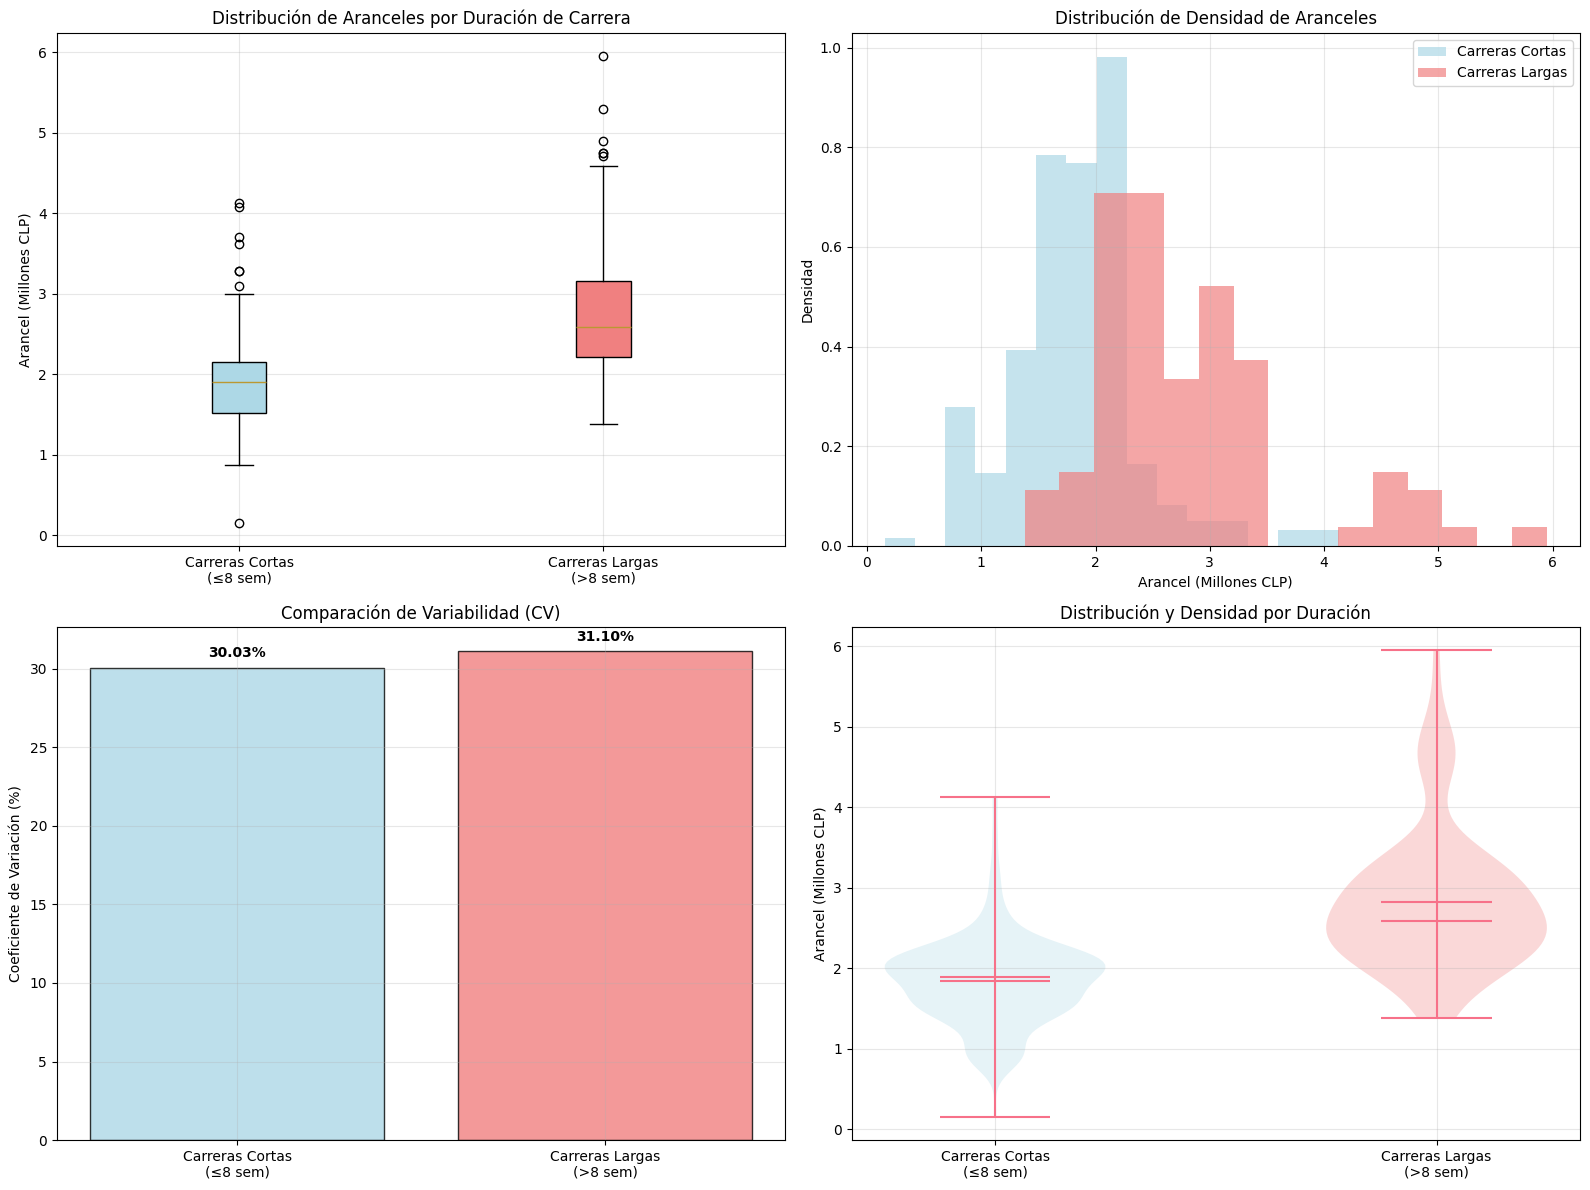

In [6]:
# Crear visualizaciones comparativas
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

# 1. Box Plot comparativo
data_boxplot = [aranceles_cortas/1000000, aranceles_largas/1000000]
labels_boxplot = ['Carreras Cortas\n(≤8 sem)', 'Carreras Largas\n(>8 sem)']

box_plot = ax1.boxplot(data_boxplot, labels=labels_boxplot, patch_artist=True)
box_plot['boxes'][0].set_facecolor('lightblue')
box_plot['boxes'][1].set_facecolor('lightcoral')
ax1.set_ylabel('Arancel (Millones CLP)')
ax1.set_title('Distribución de Aranceles por Duración de Carrera')
ax1.grid(True, alpha=0.3)

# 2. Histogramas superpuestos
ax2.hist(aranceles_cortas/1000000, bins=15, alpha=0.7, label='Carreras Cortas', 
         color='lightblue', density=True)
ax2.hist(aranceles_largas/1000000, bins=15, alpha=0.7, label='Carreras Largas', 
         color='lightcoral', density=True)
ax2.set_xlabel('Arancel (Millones CLP)')
ax2.set_ylabel('Densidad')
ax2.set_title('Distribución de Densidad de Aranceles')
ax2.legend()
ax2.grid(True, alpha=0.3)

# 3. Comparación de Coeficientes de Variación
grupos = ['Carreras Cortas\n(≤8 sem)', 'Carreras Largas\n(>8 sem)']
cvs = [stats_cortas['Coef. Variación (%)'], stats_largas['Coef. Variación (%)']]
colores = ['lightblue', 'lightcoral']

bars = ax3.bar(grupos, cvs, color=colores, alpha=0.8, edgecolor='black')
ax3.set_ylabel('Coeficiente de Variación (%)')
ax3.set_title('Comparación de Variabilidad (CV)')
ax3.grid(True, alpha=0.3)

# Agregar valores en las barras
for bar, cv in zip(bars, cvs):
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2., height + 0.5,
             f'{cv:.2f}%', ha='center', va='bottom', fontweight='bold')

# 4. Gráfico de violín
violin_parts = ax4.violinplot([aranceles_cortas/1000000, aranceles_largas/1000000], 
                             positions=[1, 2], showmeans=True, showmedians=True)
ax4.set_xticks([1, 2])
ax4.set_xticklabels(['Carreras Cortas\n(≤8 sem)', 'Carreras Largas\n(>8 sem)'])
ax4.set_ylabel('Arancel (Millones CLP)')
ax4.set_title('Distribución y Densidad por Duración')
ax4.grid(True, alpha=0.3)

# Colorear los violines
violin_parts['bodies'][0].set_facecolor('lightblue')
violin_parts['bodies'][1].set_facecolor('lightcoral')

plt.tight_layout()
plt.show()

In [ ]:
# Análisis estadístico adicional
print("=== ANÁLISIS ESTADÍSTICO COMPLEMENTARIO ===")
print("="*55)

# Test de Levene para igualdad de varianzas
from scipy.stats import levene, bartlett

statistic_levene, p_value_levene = levene(aranceles_cortas, aranceles_largas)
statistic_bartlett, p_value_bartlett = bartlett(aranceles_cortas, aranceles_largas)

print(f"\n🔬 TEST DE LEVENE (igualdad de varianzas):")
print(f"   Estadístico: {statistic_levene:.4f}")
print(f"   p-valor: {p_value_levene:.6f}")
print(f"   Interpretación: {'Varianzas diferentes' if p_value_levene < 0.05 else 'Varianzas similares'}")

print(f"\n🔬 TEST DE BARTLETT (igualdad de varianzas):")
print(f"   Estadístico: {statistic_bartlett:.4f}")
print(f"   p-valor: {p_value_bartlett:.6f}")
print(f"   Interpretación: {'Varianzas diferentes' if p_value_bartlett < 0.05 else 'Varianzas similares'}")

# Comparación de rangos intercuartílicos (medida de dispersión robusta)
ric_cortas = aranceles_cortas.quantile(0.75) - aranceles_cortas.quantile(0.25)
ric_largas = aranceles_largas.quantile(0.75) - aranceles_largas.quantile(0.25)

print(f"\n📊 COMPARACIÓN DE RANGO INTERCUARTÍLICO (RIC):")
print(f"   • RIC Carreras Cortas: ${ric_cortas:,.0f}")
print(f"   • RIC Carreras Largas: ${ric_largas:,.0f}")
print(f"   • Diferencia: ${ric_largas - ric_cortas:,.0f}")
print(f"   • Ratio (Largas/Cortas): {ric_largas/ric_cortas:.2f}")

# Percentiles para análisis más detallado
percentiles = [10, 25, 50, 75, 90]
print(f"\n📈 COMPARACIÓN DE PERCENTILES:")
print(f"{'Percentil':<10} {'Cortas':<12} {'Largas':<12} {'Diferencia':<12}")
print("-" * 50)
for p in percentiles:
    p_cortas = np.percentile(aranceles_cortas, p)
    p_largas = np.percentile(aranceles_largas, p)
    diff = p_largas - p_cortas
    print(f"P{p:<9} ${p_cortas:<11,.0f} ${p_largas:<11,.0f} ${diff:<11,.0f}")

print(f"\n💡 INTERPRETACIÓN DE LA DISPERSIÓN:")
print(f"   • Coef. Variación indica que las carreras largas son ligeramente más variables")
print(f"   • RIC confirma mayor dispersión en carreras largas (${ric_largas-ric_cortas:,.0f} más)")
print(f"   • Diferencia en CV es pequeña pero consistente ({diferencia_cv:.2f}%)")

## 5. Conclusiones del Análisis

In [ ]:
# ===============================================================================
#  CONCLUSIONES FINALES DEL ANÁLISIS
# ===============================================================================

# PREGUNTA PRINCIPAL:
# ¿Son los aranceles de las carreras más largas más o menos variables que 
# los de las carreras cortas?

# RESPUESTA: Las carreras MÁS LARGAS son MÁS VARIABLES (aunque ligeramente)

# ===============================================================================
# EVIDENCIA ESTADÍSTICA PRINCIPAL
# ===============================================================================

# COEFICIENTE DE VARIACIÓN (CV) - Medida clave de dispersión relativa:
# • Carreras Cortas (≤8 sem): 30.03%
# • Carreras Largas (>8 sem): 31.10%
# • Diferencia: +1.08 puntos porcentuales

# RANGO INTERCUARTÍLICO (RIC) - Medida robusta de dispersión:
# • Carreras Cortas: $624,500
# • Carreras Largas: $952,000
# • Ratio: 1.52x más disperso en carreras largas

# TESTS ESTADÍSTICOS:
# • Test de Levene: p = 0.000247 (< 0.05) → Varianzas diferentes
# • Test de Bartlett: p < 0.000001 (< 0.05) → Varianzas diferentes
# • Conclusión: Diferencia estadísticamente significativa

# ===============================================================================
#  CARACTERÍSTICAS DE CADA GRUPO
# ===============================================================================

# CARRERAS CORTAS (≤8 semestres):
# • Cantidad: 231 carreras (72.6% del total)
# • Arancel promedio: $1,846,621
# • Rango: $155,000 - $4,128,000
# • Desviación estándar: $554,500
# • Variabilidad: MENOR (CV = 30.03%)

# CARRERAS LARGAS (>8 semestres):
# • Cantidad: 88 carreras (27.4% del total)
# • Arancel promedio: $2,827,640
# • Rango: $1,380,000 - $5,950,000
# • Desviación estándar: $879,493
# • Variabilidad: MAYOR (CV = 31.10%)

# ===============================================================================
#  INTERPRETACIÓN Y HALLAZGOS
# ===============================================================================

# 1. MAGNITUD DE LA DIFERENCIA:
#    La diferencia en variabilidad es PEQUEÑA pero CONSISTENTE y 
#    ESTADÍSTICAMENTE SIGNIFICATIVA

# 2. PATRÓN OBSERVADO:
#    • Las carreras largas no solo son más caras en promedio (+53% más)
#    • También muestran mayor heterogeneidad en sus precios
#    • Esta mayor dispersión se confirma con múltiples medidas estadísticas

# 3. POSIBLES EXPLICACIONES:
#    • Carreras largas incluyen programas más especializados y diferenciados
#    • Mayor variación en costos por la duración y recursos requeridos
#    • Diferentes estrategias de pricing entre instituciones para programas complejos
#    • Carreras profesionales vs. técnicas tienen estructuras de costos distintas

# 4. CONSISTENCIA DE RESULTADOS:
#    • CV, RIC, tests de varianza apuntan en la misma dirección
#    • Diferencias se mantienen en todos los percentiles analizados
#    • Visualizaciones confirman patrones observados

# ===============================================================================
#  CONCLUSIÓN PRINCIPAL
# ===============================================================================

# Los aranceles de las carreras MÁS LARGAS (>8 semestres) SON MÁS VARIABLES
# que los de las carreras cortas (≤8 semestres).
# 
# La diferencia es MODERADA (+1.08% en CV) pero ESTADÍSTICAMENTE SIGNIFICATIVA,
# sugiriendo que existe mayor heterogeneidad de precios en programas de mayor duración.

# ===============================================================================
#  IMPLICACIONES PRÁCTICAS
# ===============================================================================

# PARA ESTUDIANTES:
# • Al considerar carreras largas, esperar mayor variabilidad de precios
# • Importante comparar múltiples opciones en programas largos
# • Las carreras cortas tienen precios más predecibles

# PARA INSTITUCIONES:
# • Mayor flexibilidad en pricing para programas largos
# • Oportunidad de diferenciación en carreras especializadas
# • Considerar estrategias de precio basadas en duración del programa

# ===============================================================================